In [ ]:
import jax
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
from einops import einsum, rearrange, reduce
from functools import partial

from matplotlib import pyplot as plt
import seaborn as sb
sb.set_style("whitegrid")


# Double Descent

Reproducing the experiments from the paper [Double Descent Demystified: Identifying, Interpreting & Ablating the Sources of a Deep Learning Puzzle
](https://arxiv.org/abs/2303.14151).

# Observing the phenomenon
## Polynomial Regression (Fixed dataset, increasing the number of parameters)

On pose la fonction aléatoire suivant
$$ Y(x) = 2X + \cos(25X)\\ X \sim Uniform[-1,1] $$

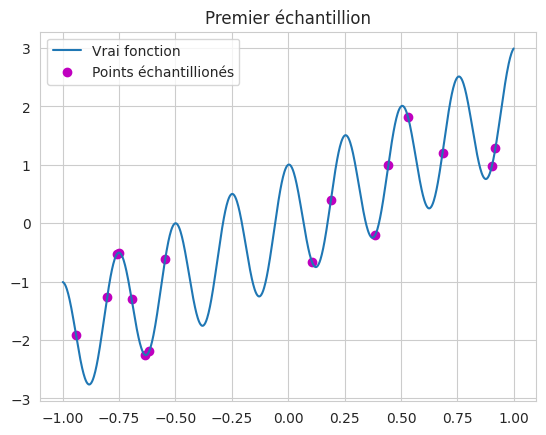

In [ ]:
def generate_polynomial_data(key, N_train):
  """
    Crée les données aléatoires X et Y pour la régression polynomiale

    Args:
        key: La clé aléatoire (PRNGKey) pour reproduire le même X
        N_train (int): Le nombre de points de données à générer

    Returns:
        Un tuple (x, y) contenant les tableaux de données générés
    """
  x = 2*random.uniform(key, shape=(N_train, 1))-1
  y = 2*x + jnp.cos(25*x)
  return x, y

key = random.PRNGKey(0)
def get_key(index):
    """Récupère une clé unique basée sur un numéro d'index."""
    return random.fold_in(key, index)

keys_stored = [get_key(i) for i in range(10)] # On garde 10 clés
N_train = 16
x_train, y_train = generate_polynomial_data(keys_stored[0], N_train)
# key, noise_key = random.split(key)
# y_train += random.normal(noise_key, y_train.shape)

x = np.linspace(-1,1,1000)
y = 2*x + jnp.cos(25*x)
plt.plot(x,y, label="Vrai fonction")
plt.scatter(x_train, y_train, c="m", label="Points échantillionés")
plt.legend()
plt.title("Premier échantillion")
plt.show()

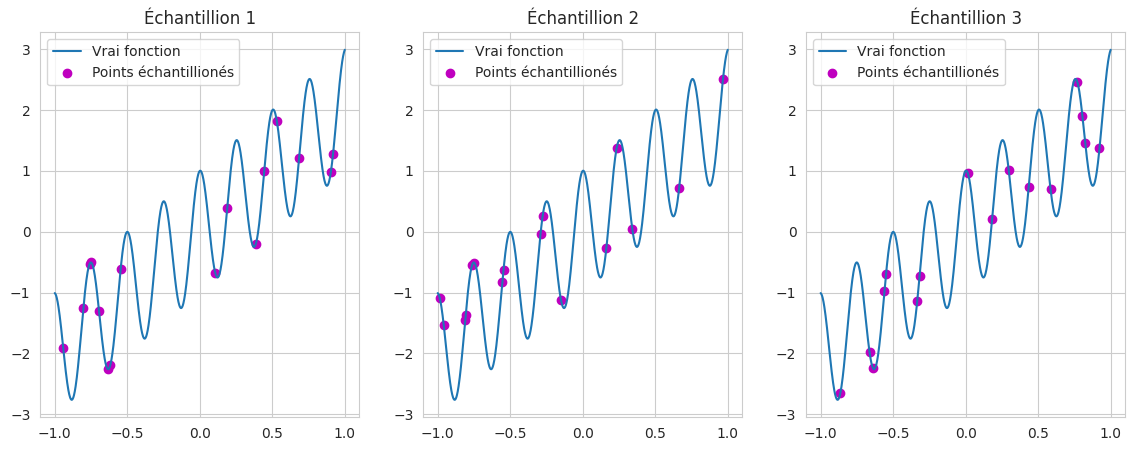

In [ ]:
plt.figure(figsize=(14,5))

for i in range(3):
  plt.subplot(1,3,i+1)
  plt.plot(x,y, label="Vrai fonction")
  x_train, y_train = generate_polynomial_data(keys_stored[i], N_train)
  plt.scatter(x_train, y_train, c="m", label="Points échantillionés")
  plt.legend()
  plt.title(f"Échantillion {i+1}")

plt.tight_layout
plt.show()

In [ ]:
from numpy.polynomial import legendre

def train_lin_model(x_train, y_train):
  assert y_train.shape == (x_train.shape[0], 1)

  def l2loss(_params):
    preds = (x_train*_params).sum(-1, keepdims=True)
    residuals = preds - y_train
    return ((residuals)**2).mean()

  loss_grad = jax.jit(jax.value_and_grad(l2loss))
  params = jnp.zeros((1,x_train.shape[1]))
  # print("params shape: ", params.shape)
  for i in range(2_000):
    loss, grad = loss_grad(params)
    # if i % 100 == 0:
    #   print(loss, (grad**2).sum())
    params += -1e-1*grad
  return params

def eval_lin_model(data, params):
  x, y = data
  preds = (x*params).sum(1, keepdims=True)
  mse = ((preds-y)**2).mean()
  return mse

def make_features(x, num_features):
  return legendre.legval(x, np.eye(num_features + 1), tensor=False)

In [ ]:
param_range = [1,2,4,8,16,20,24,32,64,128,200]
x_test = np.linspace(-1,1,1000)[:,None]
y_test = (2*x_test + jnp.cos(25*x_test))[:,None]

x_train, y_train = generate_polynomial_data(keys_stored[0], N_train)

models, train_loss, test_loss = [], [], []
for p in param_range:
  poly_features = make_features(x_train, p)
  trained_model = train_lin_model(poly_features, y_train)
  models.append(trained_model)
  train_loss.append(eval_lin_model((poly_features, y_train), trained_model))
  poly_features_test = make_features(x_test, p)
  test_loss.append(eval_lin_model((poly_features_test, y_test), trained_model))

Text(0, 0.5, 'MSE')

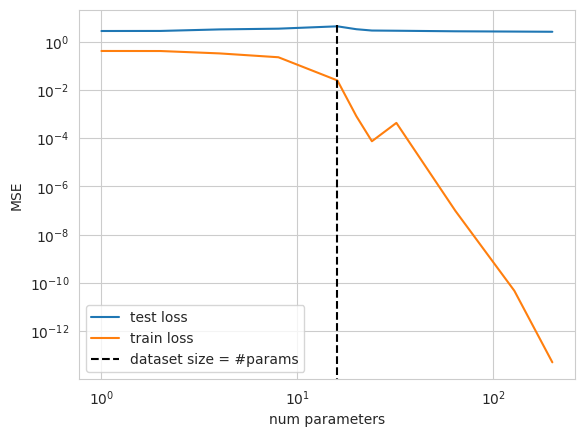

In [ ]:
plt.plot(param_range, test_loss, label="test loss")
plt.plot(param_range, train_loss, label="train loss")
plt.xscale('log')
plt.yscale('log')
#plt.ylim(1e-3,1e2)
plt.legend()
plt.vlines(N_train, 5, 0, label="dataset size = #params", linestyles="dashed", color="black")
plt.legend()
plt.xlabel("num parameters")
plt.ylabel("MSE")

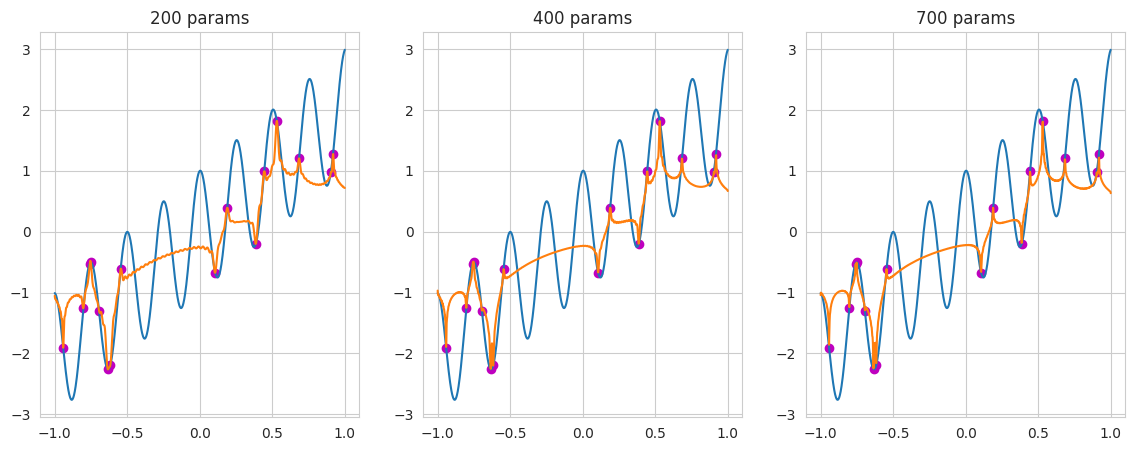

In [ ]:
x = np.linspace(-1,1,1000)[:,None]
y = 2*x + jnp.cos(25*x)

plt.figure(figsize=(14,5))
ids = [0,4,len(param_range)-1]
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.plot(x,y)
  plt.scatter(x_train, y_train, c="m")
  features = make_features(x, param_range[ids[i]])
  preds = (features*models[ids[i]]).sum(1, keepdims=True)
  plt.plot(x, preds)
  plt.title(f"{param_range[ids[i]]} params")

In [ ]:
param_range = [200,250,300,350,400,450,500,550,600,650,700]
x_test = np.linspace(-1,1,1000)[:,None]
y_test = (2*x_test + jnp.cos(25*x_test))[:,None]

models, train_loss, test_loss = [], [], []
for p in param_range:
  poly_features = make_features(x_train, p)
  trained_model = train_lin_model(poly_features, y_train)
  models.append(trained_model)
  train_loss.append(eval_lin_model((poly_features, y_train), trained_model))
  poly_features_test = make_features(x_test, p)
  test_loss.append(eval_lin_model((poly_features_test, y_test), trained_model))

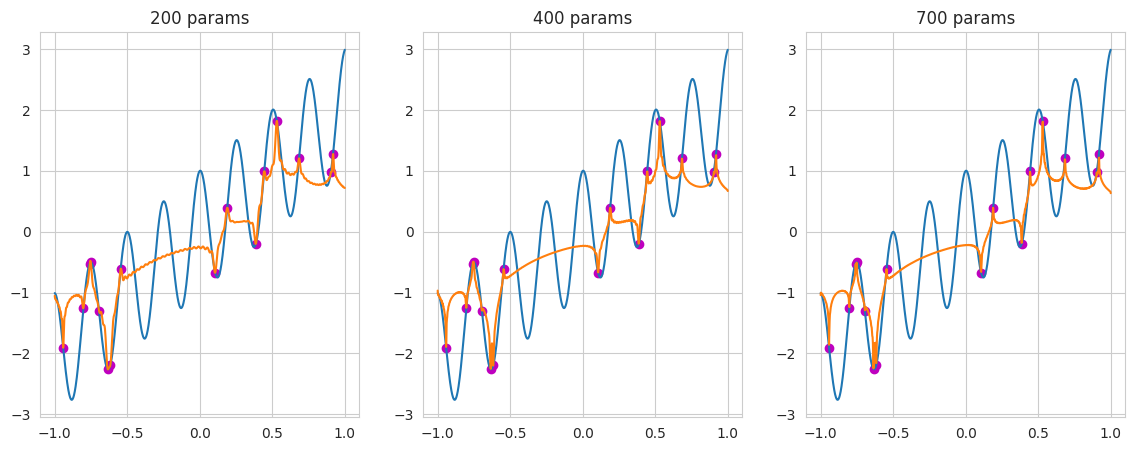

In [ ]:
x = np.linspace(-1,1,1000)[:,None]
y = 2*x + jnp.cos(25*x)

plt.figure(figsize=(14,5))
ids = [0,4,len(param_range)-1]
for i in range(3):
  plt.subplot(1,3,i+1)
  plt.plot(x,y)
  plt.scatter(x_train, y_train, c="m")
  features = make_features(x, param_range[ids[i]])
  preds = (features*models[ids[i]]).sum(1, keepdims=True)
  plt.plot(x, preds)
  plt.title(f"{param_range[ids[i]]} params")

Je crois que le phénomène de double descente dans ces données est le fait que la fonction aléatoire est une fonction ondulatoire et que le modèle commence à apprendre que c'est une fonction aléatoire ondulatoire

Essayons une différente expérience. Au lieu de garder les même données ${X_i,Y_i}$ et d'augmenter les paramètres, on change les données mais on garde le même nombre de paramètre

In [ ]:
def prediction(x, x_train, y_train, n_params, key, N_train = 16):
    x_train, y_train = generate_polynomial_data(keys_stored[i], N_train)
    poly_features = make_features(x_train, NUM_PARAMS)
    model_weights = train_lin_model(poly_features, y_train)  # On apprend les poids

    features_grid = make_features(x, NUM_PARAMS)
    return features_grid @ model_weights.T

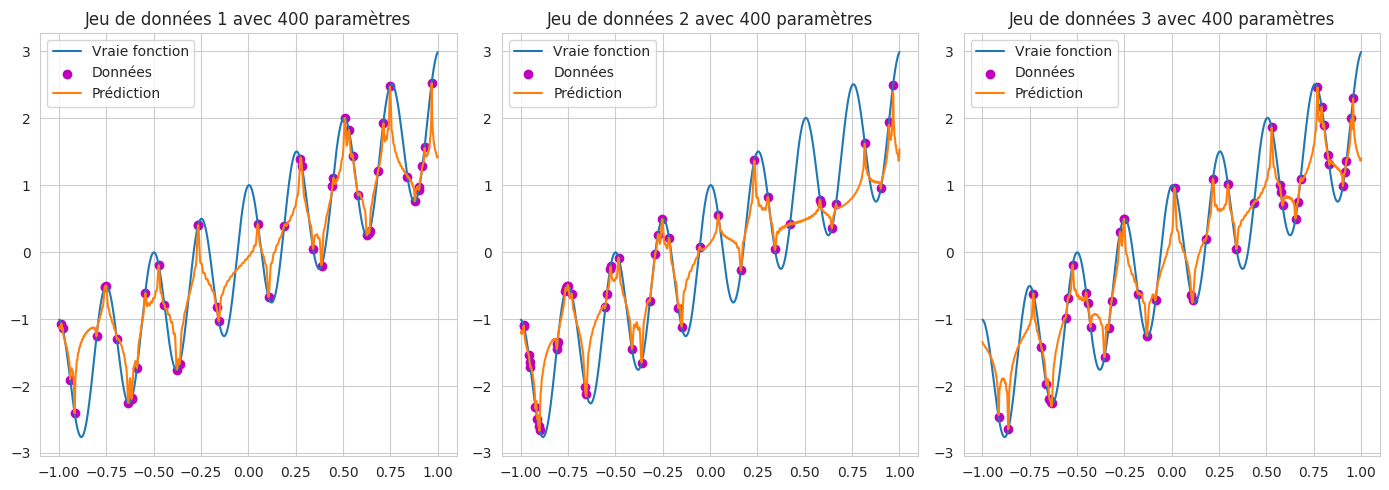

In [ ]:
NUM_PARAMS = 400
x = np.linspace(-1,1,1000)[:,None]
y = 2*x + jnp.cos(25*x)
plt.figure(figsize=(14, 5))

for i in range(3):
    plt.subplot(1, 3, i+1)

    # 1. Échantillonnage de points de la vrai fonction
    x_train, y_train = generate_polynomial_data(keys_stored[i], N_train)
    plt.plot(x, y, label="Vraie fonction")
    plt.scatter(x_train, y_train, c="m", label="Données")


    # Prédiction

    preds_grid = prediction(x, x_train, y_train, NUM_PARAMS, keys_stored[i],N_train)
    plt.plot(x, preds_grid, label="Prédiction")
    plt.title(f"Jeu de données {i+ 1} avec {NUM_PARAMS} paramètres")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


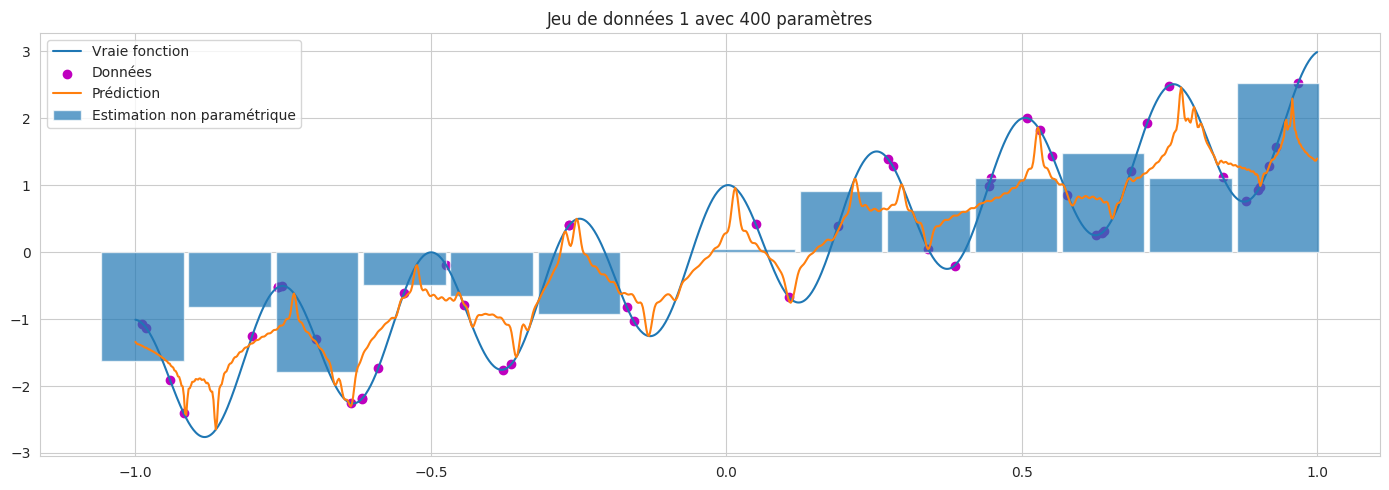

In [ ]:
def bacs(vec_X, vec_Y, nb_bacs= 10):
  vec_X = vec_X.flatten()
  vec_Y = vec_Y.flatten()
  pas = abs(max(vec_X) + 1 - min(vec_X)) / nb_bacs
  bacs = []
  val_actuel = min(vec_X)
  while val_actuel < max(vec_X) + 1e-6:
    masque = (vec_X >= val_actuel) & (vec_X < val_actuel + pas)
    valeur = vec_Y[masque].mean()
    bacs.append(valeur)
    val_actuel += pas
  x = [min(vec_X) + i * pas for i in range(0, len(bacs))]
  return x, bacs

plt.figure(figsize=(14, 5))

x_train, y_train = generate_polynomial_data(keys_stored[0], N_train)

# Tracer la vraie fonction
plt.plot(x, y, label="Vraie fonction")

plt.scatter(x_train, y_train, c="m", label="Données")

x_bac, b = bacs(x_train,y_train, 20)
plt.bar(x_bac, b, alpha = 0.7,width = abs(max(x_train)-min(x_train))/len(b),label="Estimation non paramétrique")

# Prédiction
preds = prediction(x, x_train, y_train, NUM_PARAMS,keys_stored[0], N_train)

plt.plot(x, preds, label="Prédiction")
plt.title(f"Jeu de données {1} avec {NUM_PARAMS} paramètres")


plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()




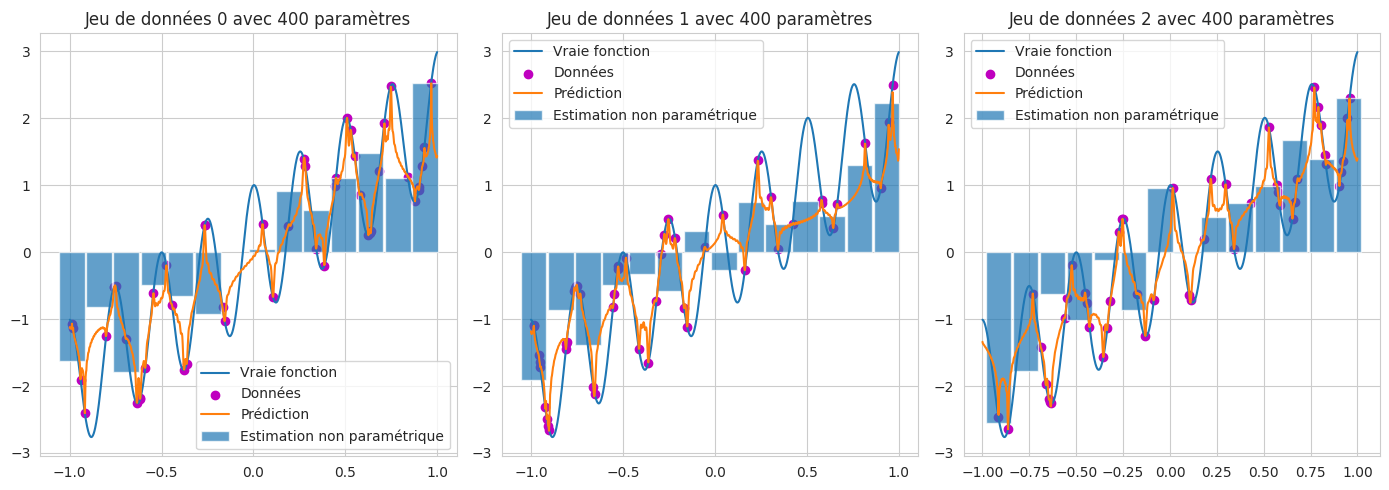

In [ ]:
plt.figure(figsize=(14, 5))

liste_bacs = []
for i in range(3):
    plt.subplot(1, 3, i+1)

    # 3. RÉCUPÉRATION : On reprend les points spécifiques à ce modèle
    x_train, y_train = generate_polynomial_data(keys_stored[i], N_train)

    # Tracer la vraie fonction
    plt.plot(x, y, label="Vraie fonction")

    # Tracer les points
    plt.scatter(x_train, y_train, c="m", label="Données")

    # Les bacs non paramétrique
    x_bac, b = bacs(x_train,y_train, 20)
    liste_bacs.append(b)
    plt.bar(x_bac, b, alpha = 0.7,width = abs(max(x_train)-min(x_train))/len(b),label="Estimation non paramétrique")
    # Prédiction
    preds = prediction(x, x_train, y_train, NUM_PARAMS, keys_stored[i], N_train)

    plt.plot(x, preds, label="Prédiction")
    plt.title(f"Jeu de données {i} avec {NUM_PARAMS} paramètres")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Changeons le domaine de la fonction et le nombre de points échantillonnés

$$X \sim Unif[-2, 2]$$

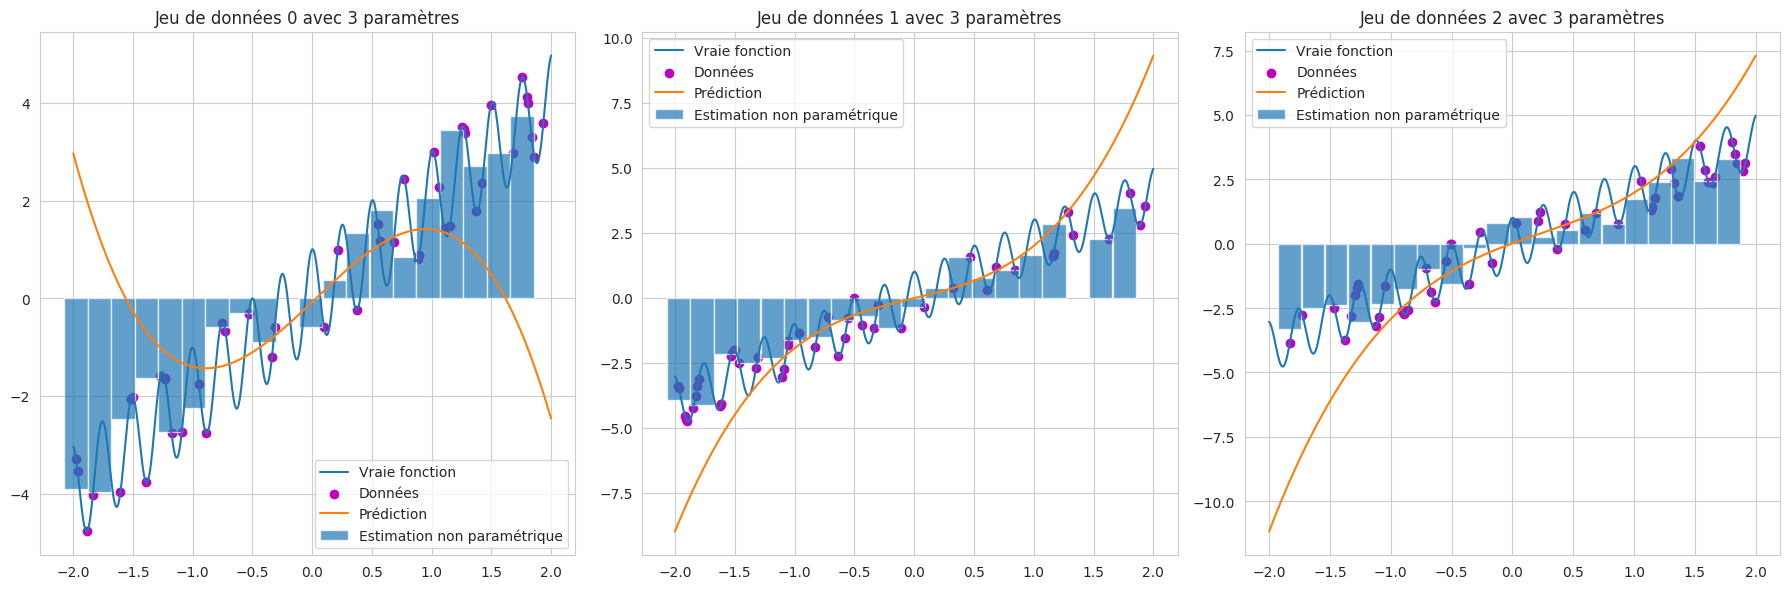

In [ ]:
def generate_polynomial_data_diff_range(key, N_train):
  """
    Crée les données aléatoires X et Y pour la régression polynomiale

    Args:
        key: La clé aléatoire (PRNGKey) pour reproduire le même X
        N_train (int): Le nombre de points de données à générer

    Returns:
        Un tuple (x, y) contenant les tableaux de données générés
    """
  x = random.uniform(key, shape=(N_train, 1), minval=-2, maxval=2.0)
  y = 2*x + jnp.cos(25*x)
  return x, y

plt.figure(figsize=(18, 6))
x = np.linspace(-2,2,1000)[:,None]
y = 2*x + jnp.cos(25*x)
N_train  = 16 * 3
NUM_PARAMS = 3
liste_bacs = []
for i in range(3):
    plt.subplot(1, 3, i+1)

    # 3. RÉCUPÉRATION : On reprend les points spécifiques à ce modèle
    x_train, y_train = generate_polynomial_data_diff_range(keys_stored[i], N_train)

    # Tracer la vraie fonction
    plt.plot(x, y, label="Vraie fonction")

    # Tracer les points
    plt.scatter(x_train, y_train, c="m", label="Données")
    # Les bacs non paramétrique
    x_bac, b = bacs(x_train,y_train, 25)
    liste_bacs.append(b)
    plt.bar(x_bac, b, alpha = 0.7,width = abs(max(x_train)-min(x_train))/len(b),label="Estimation non paramétrique")
    # Prédiction
    preds = prediction(x, x_train, y_train, NUM_PARAMS, keys_stored[i], N_train)

    plt.plot(x, preds, label="Prédiction")
    plt.title(f"Jeu de données {i} avec {NUM_PARAMS} paramètres")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
def différence_bacs(b):
  diff = np.zeros(len(b)-1)
  for i in range(len(b)-1):
    diff[i] = b[i + 1] - b[i]
  return diff

def approx_dériv_morceaux(b):
  quot = np.zeros(len(b)-1)
  diff = différence_bacs(b)
  for i in range(len(diff)-1):
    quot[i] = diff[i + 1] / diff[i]
  return quot

def statistique(b, batch=len(b)):
    # Codes ANSI pour les couleurs
    VERT = "\033[92m"
    ROUGE = "\033[91m"
    RESET = "\033[0m"

    # Petite fonction aide pour formater le nombre
    def fmt(valeur):
        # Choisir la couleur
        couleur = VERT if valeur >= 0 else ROUGE
        # Retourne: COULEUR + le nombre (arrondi à 4 décimales) + RESET
        return f"{couleur}{valeur:.4f}{RESET}"

    d = différence_bacs(b)
    q = approx_dériv_morceaux(b)

    taille_fenêtre = int(len(d) / batch)

    # S'assurer que la fenêtre a une taille minimale de 1
    if taille_fenêtre < 1: taille_fenêtre = 1

    print(f"{'Somme Diff':>15} | {'Somme Dérivée':>15}")
    print("-" * 35)

    # Note: J'ai enlevé le "+1" dans le slice pour avoir des fenêtres disjointes exactes
    # Si vous voulez que ça se touche, utilisez juste 'taille_fenêtre'
    for i in range(0, len(d), taille_fenêtre):

        # On s'assure de ne pas dépasser le tableau (slicing sécurisé)
        fin = min(i + taille_fenêtre, len(d))

        # Si on est au bout et que la fenêtre est trop petite, on arrête ou on continue selon votre besoin
        if i >= len(d): break

        somme = d[i : fin].sum()
        quotient = q[i : fin].sum()

        # Appel de la fonction couleur
        print(f"Diff: {fmt(somme)} | Dériv: {fmt(quotient)}")
statistique(liste_bacs[2])

     Somme Diff |   Somme Dérivée
-----------------------------------
Diff: 0.8061 | Dériv: 0.1626
Diff: 0.1311 | Dériv: -5.0867
Diff: -0.6669 | Dériv: -1.0421
Diff: 0.6950 | Dériv: 0.8201
Diff: 0.5700 | Dériv: 1.3997
Diff: 0.7978 | Dériv: -0.7481
Diff: -0.5968 | Dériv: -2.3567
Diff: 1.4066 | Dériv: 0.6743
Diff: 0.9484 | Dériv: 0.2620
Diff: 0.2485 | Dériv: -3.1027
Diff: -0.7711 | Dériv: -0.3572
Diff: 0.2754 | Dériv: 2.3113
Diff: 0.6365 | Dériv: -0.6361
Diff: -0.4048 | Dériv: -2.3815
Diff: 0.9641 | Dériv: 0.6619
Diff: 0.6381 | Dériv: 1.4791
Diff: 0.9438 | Dériv: -0.9268
Diff: -0.8748 | Dériv: -0.9766
Diff: 0.8543 | Dériv: 0.0000


On observer le phénomène ondulatoire typique d'une fonction ondulatoire. Les groupes de bacs varient entre positif et négatif. Celà implique que la fonction polynomiale de ne peut pas expliquer l'ondulation de la fonction

On choisit alors une différente famille de fonction
$$
\mathcal{F} = \{x,\;x^2,x^3,\; cos(x),\; sin(x),\; x^2cos(x),\; x^2sin(x),\; x^3cos(x),\; x^3sin(x)\}
$$

# Linear regression

In [ ]:
N_test, D = 1_000, 20
train_sizes = [1,2,4,8,16,19,20,21,24,32,64,128,256,512,1024]

def generate_data(key, N_train, N_test, D):
  keys = random.split(key, 3)
  beta = random.normal(keys[0], (1,D))
  x = 2*random.uniform(keys[1], shape=(N_train + N_test, D))-1
  sigma = 10
  noise = sigma*random.normal(keys[2], (N_train + N_test, 1))
  y = (beta*x).sum(-1, keepdims=True) + noise
  return (x[:N_train], y[:N_train]), (x[N_train:], y[N_train:])

def add_constant(x):
  return jnp.concatenate([jnp.ones((x.shape[0],1)), x], axis=1)

def genereate_plots(key, train_func):
  key, data_key = random.split(key)

  data_train, data_test = generate_data(data_key, max(train_sizes), N_test, D)
  train_loss, test_loss, lowest_s = [], [], []
  for N_train in train_sizes:
    x_train, y_train = add_constant(data_train[0][:N_train]), data_train[1][:N_train]
    model = train_func(x_train, y_train)
    train_loss.append(eval_lin_model((x_train, y_train), model))
    x_test, y_test = add_constant(data_test[0]), data_test[1]
    test_loss.append(eval_lin_model((x_test, y_test), model))
    lowest_s.append(jnp.linalg.svd(x_train.T).S.min())
  return np.array(train_loss), np.array(test_loss), np.array(lowest_s)

In [ ]:
key = random.PRNGKey(0)
n_experiments = 10
keys = random.split(key, n_experiments)
train_loss, test_loss, lowest_s = [], [], []
for i in range(n_experiments):
  train_loss_i, test_loss_i, lowest_s_i = genereate_plots(keys[i], train_lin_model)
  train_loss.append(train_loss_i)
  test_loss.append(test_loss_i)
  lowest_s.append(lowest_s_i)
train_loss = np.stack(train_loss)
test_loss = np.stack(test_loss)
lowest_s = np.stack(lowest_s)

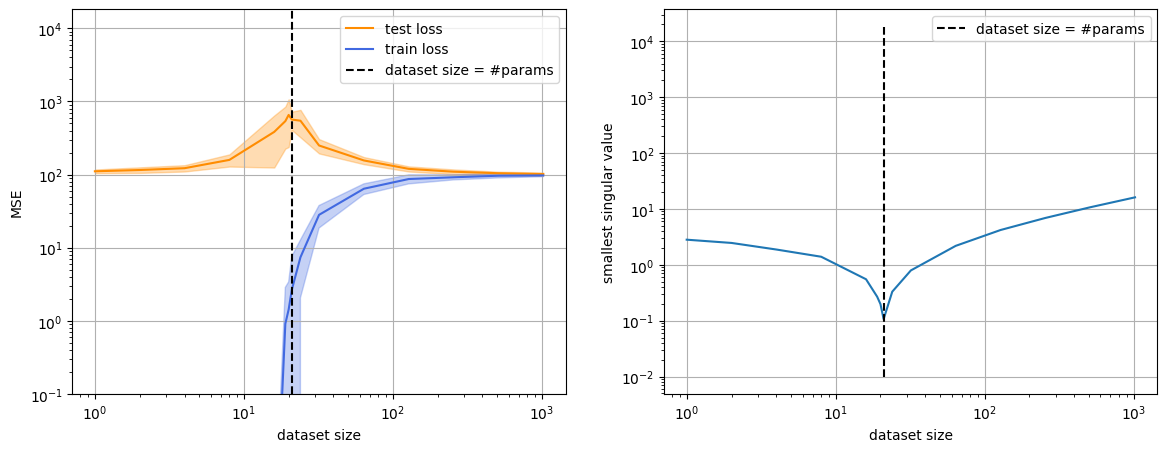

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(train_sizes, test_loss.mean(0), label="test loss", color="darkorange")
plt.fill_between(train_sizes, test_loss.mean(0)-test_loss.std(0),
                 test_loss.mean(0)+test_loss.std(0),
                 color="darkorange", alpha=0.3)
plt.plot(train_sizes, train_loss.mean(0), label="train loss", color="royalblue")
plt.fill_between(train_sizes, train_loss.mean(0)-train_loss.std(0),
                 train_loss.mean(0)+train_loss.std(0),
                 color="royalblue", alpha=0.3)
plt.vlines(D+1, 1e-1, 10*test_loss.max(), label="dataset size = #params", linestyles="dashed", color="black")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1,10*test_loss.max())
plt.legend()
plt.xlabel("dataset size")
plt.ylabel("MSE")
plt.grid()

plt.subplot(122)
plt.plot(train_sizes, lowest_s.mean(0))
plt.vlines(D+1, 1e-2, 10*test_loss.max(), label="dataset size = #params", linestyles="dashed", color="black")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("dataset size")
plt.ylabel("smallest singular value")
plt.legend()
plt.grid()

# Solving Double Descent

In [ ]:
def train_ridge_model(x_train, y_train, ridge=1.0):
  assert y_train.shape == (x_train.shape[0], 1)

  def l2loss(_params):
    preds = (x_train*_params).sum(-1, keepdims=True)
    residuals = preds - y_train
    return ((residuals)**2).mean() + ridge*((_params[0,:-1])**2).mean()

  loss_grad = jax.jit(jax.value_and_grad(l2loss))
  params = jnp.zeros((1,x_train.shape[1]))
  # print("params shape: ", params.shape)
  for i in range(2_000):
    loss, grad = loss_grad(params)
    # if i % 100 == 0:
    #   print(loss, (grad**2).sum())
    params += -1e-1*grad
  return params

In [ ]:
key = random.PRNGKey(0)
ridge_values = np.logspace(-4,2,7)
train_loss, test_loss, lowest_s = [], [], []
for ridge in ridge_values:
  train_loss_i, test_loss_i, lowest_s_i = genereate_plots(key, lambda _x,_y: train_ridge_model(_x, _y, ridge))
  train_loss.append(train_loss_i)
  test_loss.append(test_loss_i)
  lowest_s.append(lowest_s_i)
train_loss = np.stack(train_loss)
test_loss = np.stack(test_loss)
lowest_s = np.stack(lowest_s)

In [ ]:
import seaborn as sns
palette_train = sns.color_palette("rocket", n_colors=7)
palette_test = sns.color_palette("mako", n_colors=7)
palette_test

[(0.16914226, 0.10805832, 0.20589698),
 (0.24423453, 0.20678459, 0.41985299),
 (0.23318874, 0.33648036, 0.59775543),
 (0.20692679, 0.48201774, 0.63812656),
 (0.20795035, 0.62210845, 0.66867802),
 (0.29215894, 0.76144162, 0.67886578),
 (0.60028928, 0.86793835, 0.71523675)]

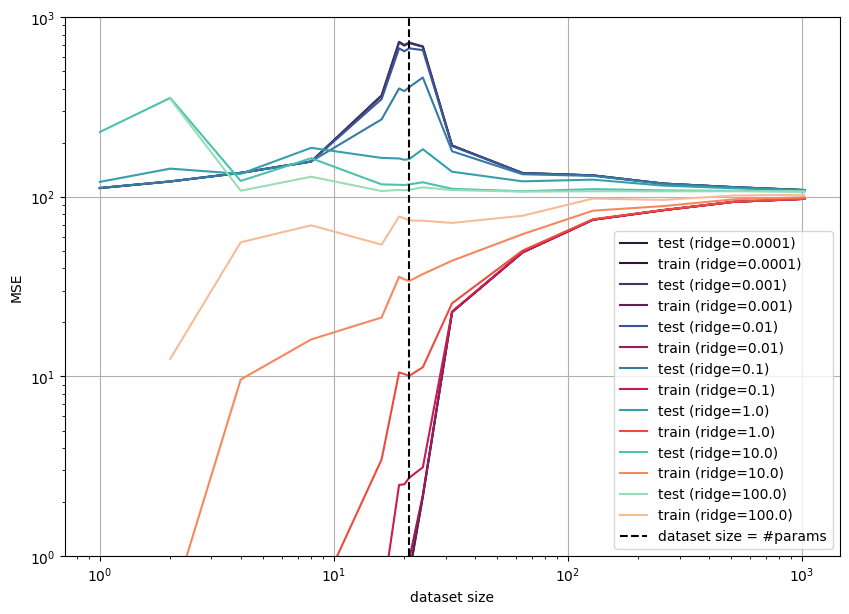

In [ ]:
plt.figure(figsize=(10,7))
for i in range(len(ridge_values)):
  plt.plot(train_sizes, test_loss[i], label=f"test (ridge={ridge_values[i]})", color=palette_test[i])
  plt.plot(train_sizes, train_loss[i], label=f"train (ridge={ridge_values[i]})", color=palette_train[i])
plt.vlines(D+1, 1e0, 1e3, label="dataset size = #params", linestyles="dashed", color="black")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e0,1e3)
plt.legend()
plt.xlabel("dataset size")
plt.ylabel("MSE")
plt.grid()

In [ ]:
key = random.PRNGKey(0)
keys = random.split(key, n_experiments)
ridge = 5
train_loss, test_loss, lowest_s = [], [], []
for i in range(n_experiments):
  train_loss_i, test_loss_i, lowest_s_i = genereate_plots(keys[i], lambda _x,_y: train_ridge_model(_x, _y, ridge))
  train_loss.append(train_loss_i)
  test_loss.append(test_loss_i)
  lowest_s.append(lowest_s_i)
train_loss = np.stack(train_loss)
test_loss = np.stack(test_loss)
lowest_s = np.stack(lowest_s)

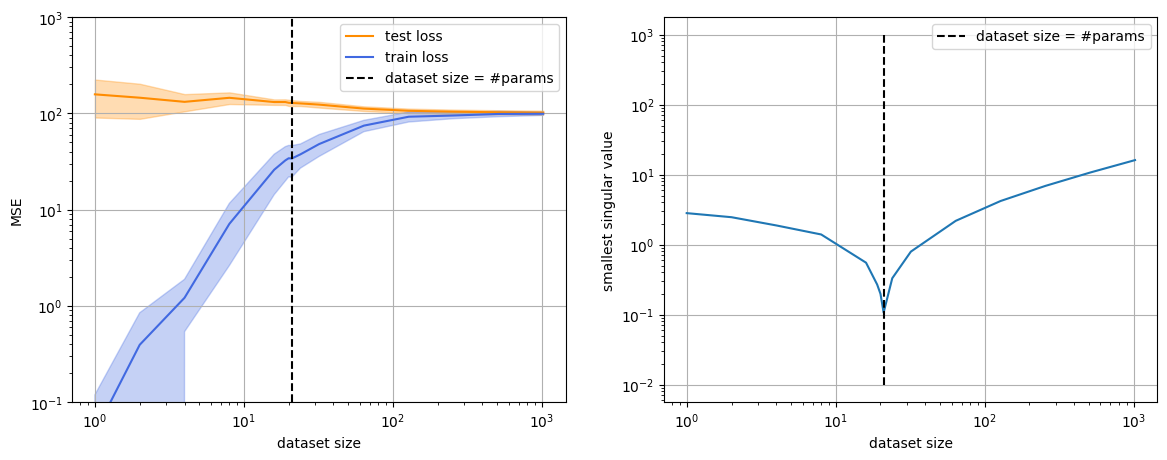

In [ ]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(train_sizes, test_loss.mean(0), label="test loss", color="darkorange")
plt.fill_between(train_sizes, test_loss.mean(0)-test_loss.std(0),
                 test_loss.mean(0)+test_loss.std(0),
                 color="darkorange", alpha=0.3)
plt.plot(train_sizes, train_loss.mean(0), label="train loss", color="royalblue")
plt.fill_between(train_sizes, train_loss.mean(0)-train_loss.std(0),
                 train_loss.mean(0)+train_loss.std(0),
                 color="royalblue", alpha=0.3)
plt.vlines(D+1, 1e-1, 1e3, label="dataset size = #params", linestyles="dashed", color="black")
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-1,1e3)
plt.legend()
plt.xlabel("dataset size")
plt.ylabel("MSE")
plt.grid()

plt.subplot(122)
plt.plot(train_sizes, lowest_s.mean(0))
plt.vlines(D+1, 1e-2, 1e3, label="dataset size = #params", linestyles="dashed", color="black")
plt.xscale('log')
plt.yscale('log')
plt.xlabel("dataset size")
plt.ylabel("smallest singular value")
plt.legend()
plt.grid()